In [1]:
!pip install pandas numpy scikit-learn xgboost matplotlib seaborn imbalanced-learn

In [2]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current working directory:", current_directory)

Current working directory: /content


Missing values after cleaning:
Type                     0
Air_temperature_K        0
Process_temperature_K    0
Rotational_speed_rpm     0
Torque_Nm                0
Tool_wear_min            0
Target                   0
Failure_Type             0
dtype: int64


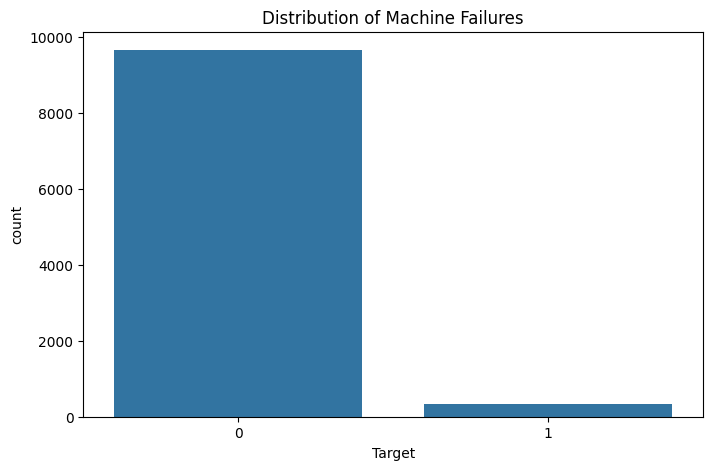

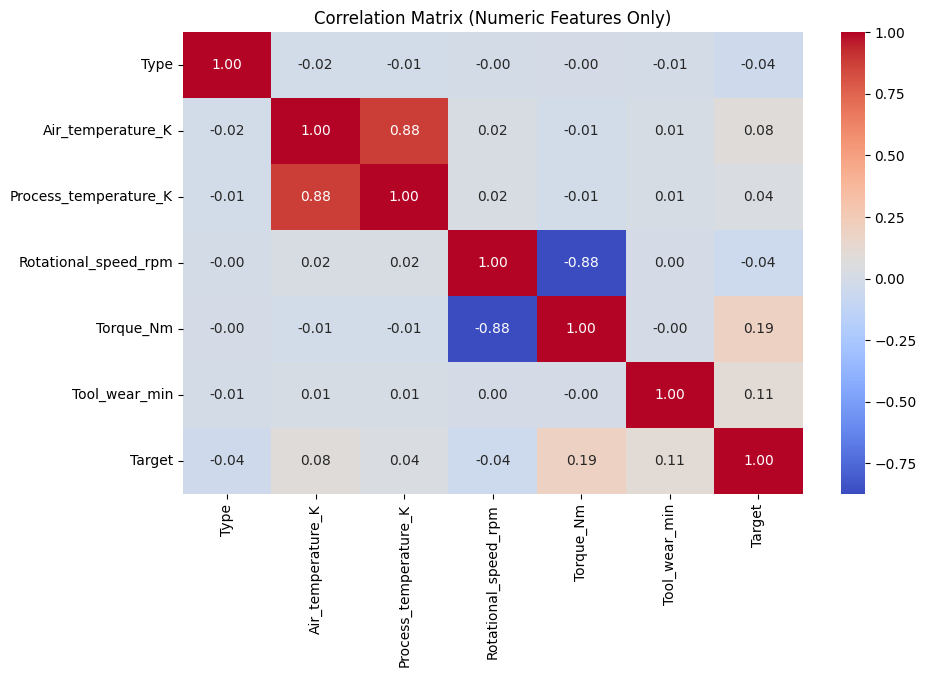

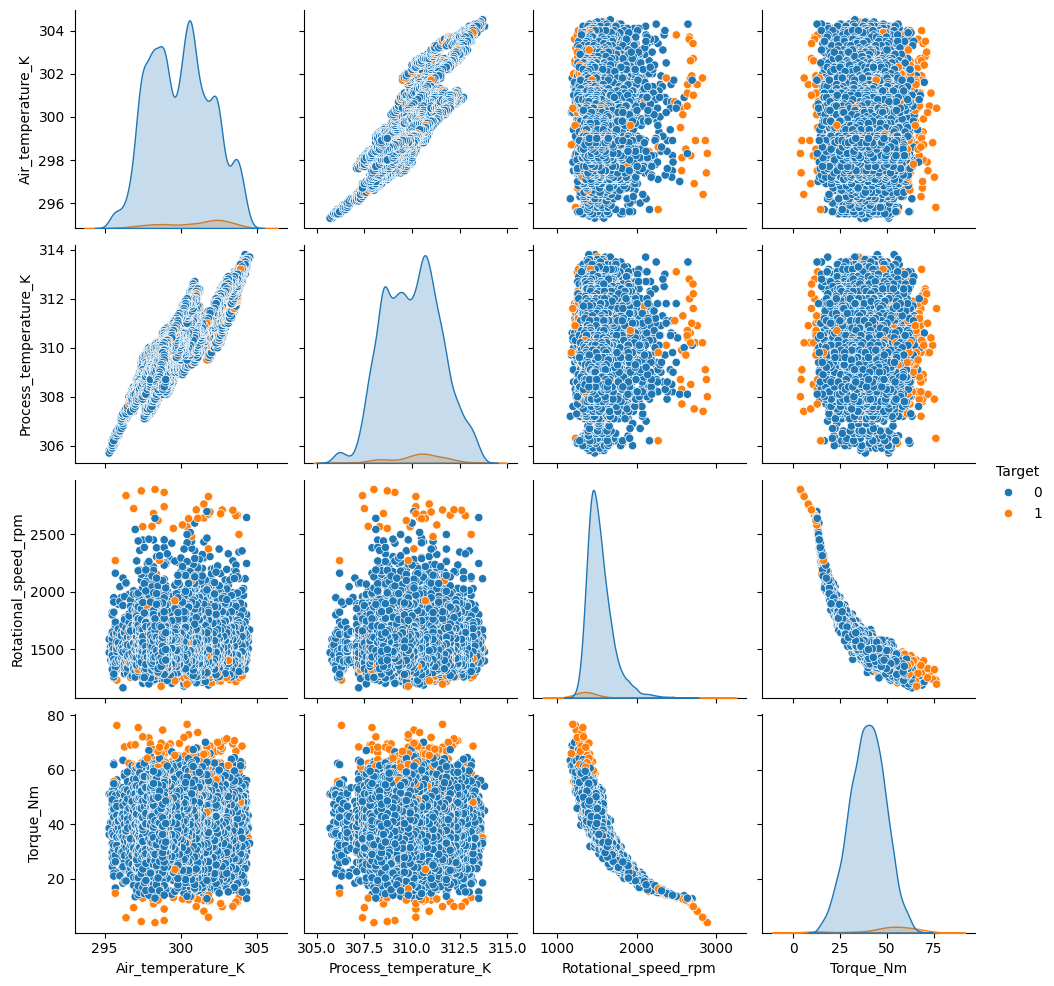

               Type  Air_temperature_K  Process_temperature_K  \
count  10000.000000       10000.000000           10000.000000   
mean       0.500300         300.004930             310.005560   
std        0.671301           2.000259               1.483734   
min        0.000000         295.300000             305.700000   
25%        0.000000         298.300000             308.800000   
50%        0.000000         300.100000             310.100000   
75%        1.000000         301.500000             311.100000   
max        2.000000         304.500000             313.800000   

       Rotational_speed_rpm     Torque_Nm  Tool_wear_min        Target  
count          10000.000000  10000.000000   10000.000000  10000.000000  
mean            1538.776100     39.986910     107.951000      0.033900  
std              179.284096      9.968934      63.654147      0.180981  
min             1168.000000      3.800000       0.000000      0.000000  
25%             1423.000000     33.200000      53

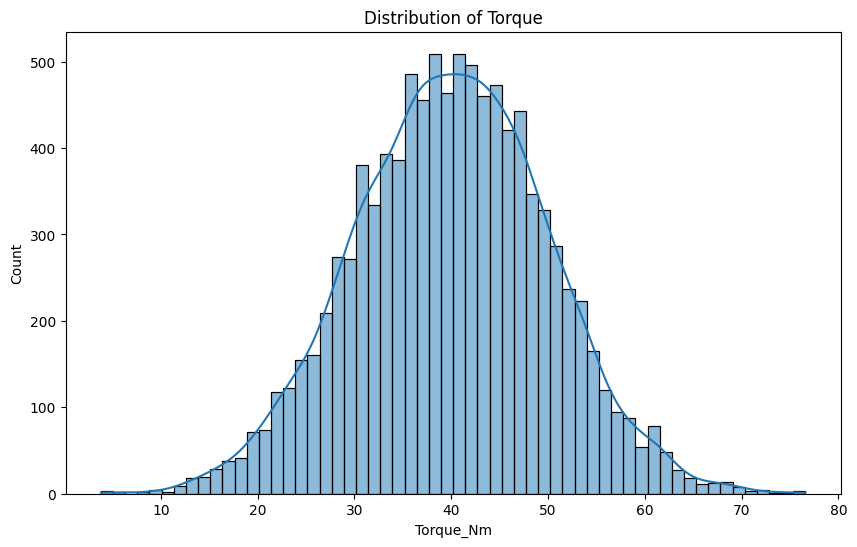

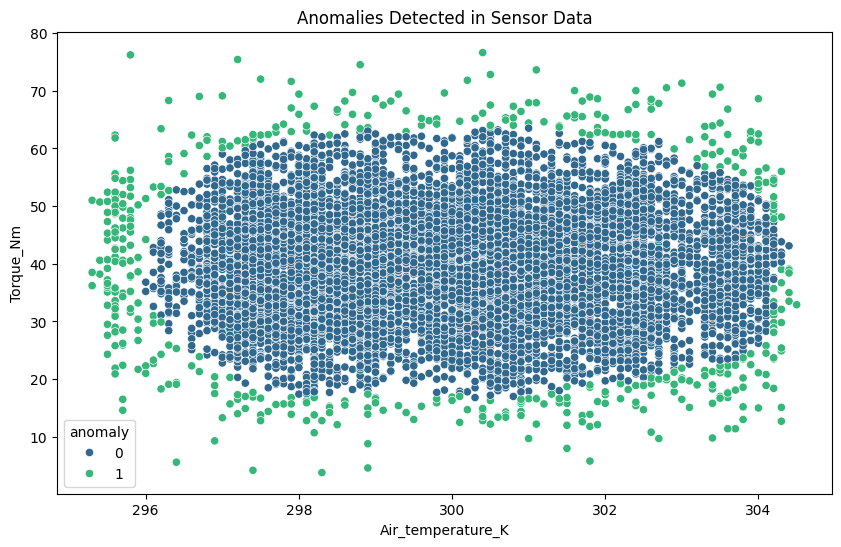

Random Forest Results:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1934
           1       0.97      0.99      0.98      1931

    accuracy                           0.98      3865
   macro avg       0.98      0.98      0.98      3865
weighted avg       0.98      0.98      0.98      3865

ROC-AUC Score: 1.00


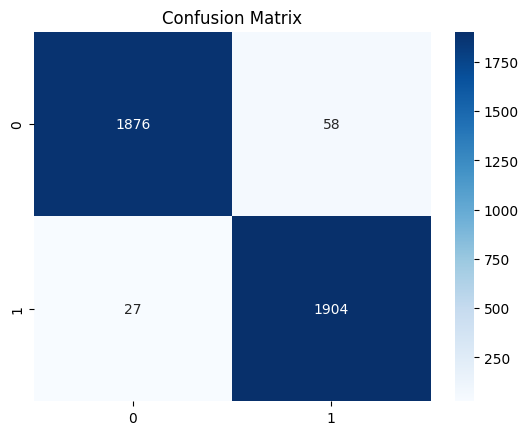


XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1934
           1       0.97      1.00      0.98      1931

    accuracy                           0.98      3865
   macro avg       0.98      0.98      0.98      3865
weighted avg       0.98      0.98      0.98      3865

ROC-AUC Score: 1.00


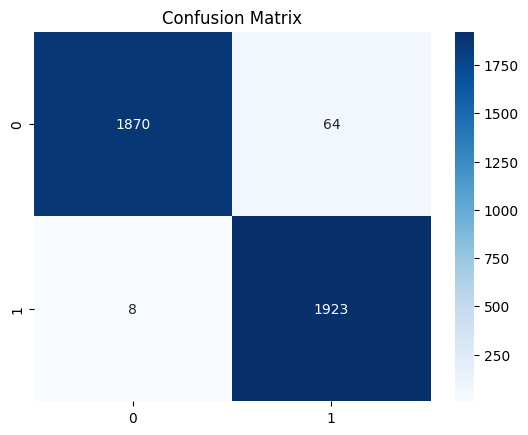

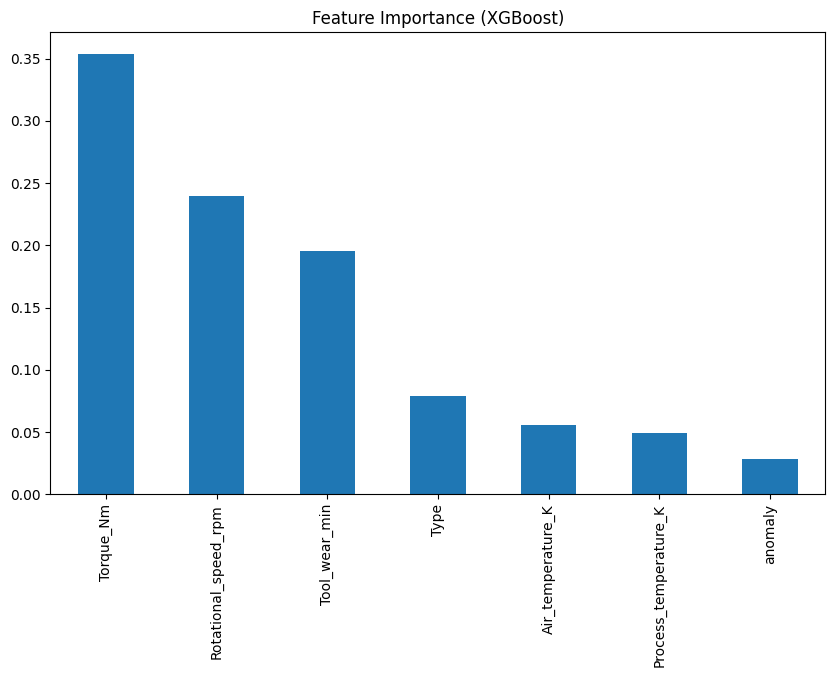

In [7]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv('predictive_maintenance.csv')

#  Data Cleaning
# -------------------------------
# Drop irrelevant columns
df = df.drop(['UDI', 'Product ID'], axis=1)

# Clean feature names (remove brackets/spaces)
df.columns = df.columns.str.replace('[', '').str.replace(']', '')
df.columns = df.columns.str.replace(' ', '_')

# Encode 'Type' column (L=0, M=1, H=2)
df['Type'] = df['Type'].map({'L': 0, 'M': 1, 'H': 2})

# Verify no missing values
print("Missing values after cleaning:")
print(df.isnull().sum())

# Exploratory Data Analysis (EDA)
# -------------------------------
# Distribution of failures
plt.figure(figsize=(8, 5))
sns.countplot(x='Target', data=df)
plt.title('Distribution of Machine Failures')
plt.show()

# Correlation matrix (numeric columns only)
numeric_df = df.select_dtypes(include='number')
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Numeric Features Only)')
plt.show()

# Pairplot for key features (numeric only)
sns.pairplot(numeric_df[['Air_temperature_K', 'Process_temperature_K',
                        'Rotational_speed_rpm', 'Torque_Nm', 'Target']],
             hue='Target', diag_kind='kde')
plt.show()

print(df.describe())  # Summary stats for numeric features

plt.figure(figsize=(10, 6))
sns.histplot(df['Torque_Nm'], kde=True)
plt.title('Distribution of Torque')
plt.show()



#  Anomaly Detection (Isolation Forest)
# -------------------------------
# Use sensor data to detect anomalies
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomalies = iso_forest.fit_predict(df[['Air_temperature_K', 'Torque_Nm']])

# Add anomaly labels to dataframe
df['anomaly'] = np.where(anomalies == -1, 1, 0)

# Visualize anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Air_temperature_K', y='Torque_Nm', hue='anomaly', data=df, palette='viridis')
plt.title('Anomalies Detected in Sensor Data')
plt.show()

#  Prepare Data for Modeling
# -------------------------------
# Separate features (X) and target (y)
X = df.drop(['Target', 'Failure_Type'], axis=1)
y = df['Target']

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

#  Model Training & Evaluation
# -------------------------------
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train XGBoost
xgb_model = XGBClassifier(scale_pos_weight=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.2f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

print("Random Forest Results:")
evaluate_model(rf_model, X_test, y_test)

print("\nXGBoost Results:")
evaluate_model(xgb_model, X_test, y_test)

#  Feature Importance
# -------------------------------
plt.figure(figsize=(10, 6))
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance (XGBoost)')
plt.show()

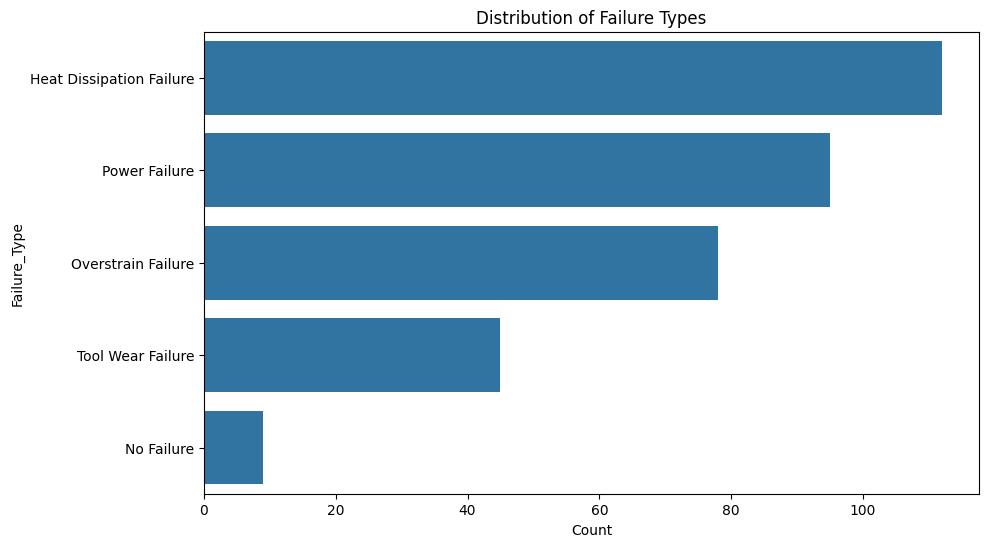

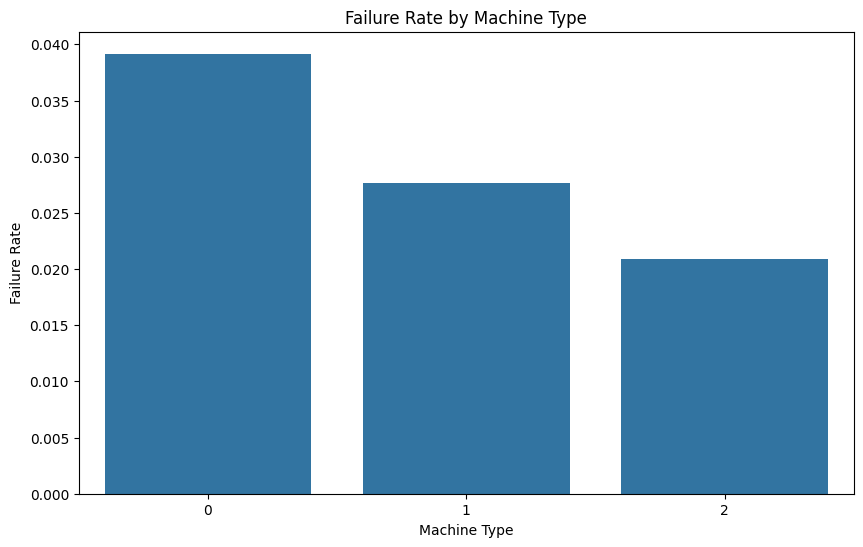

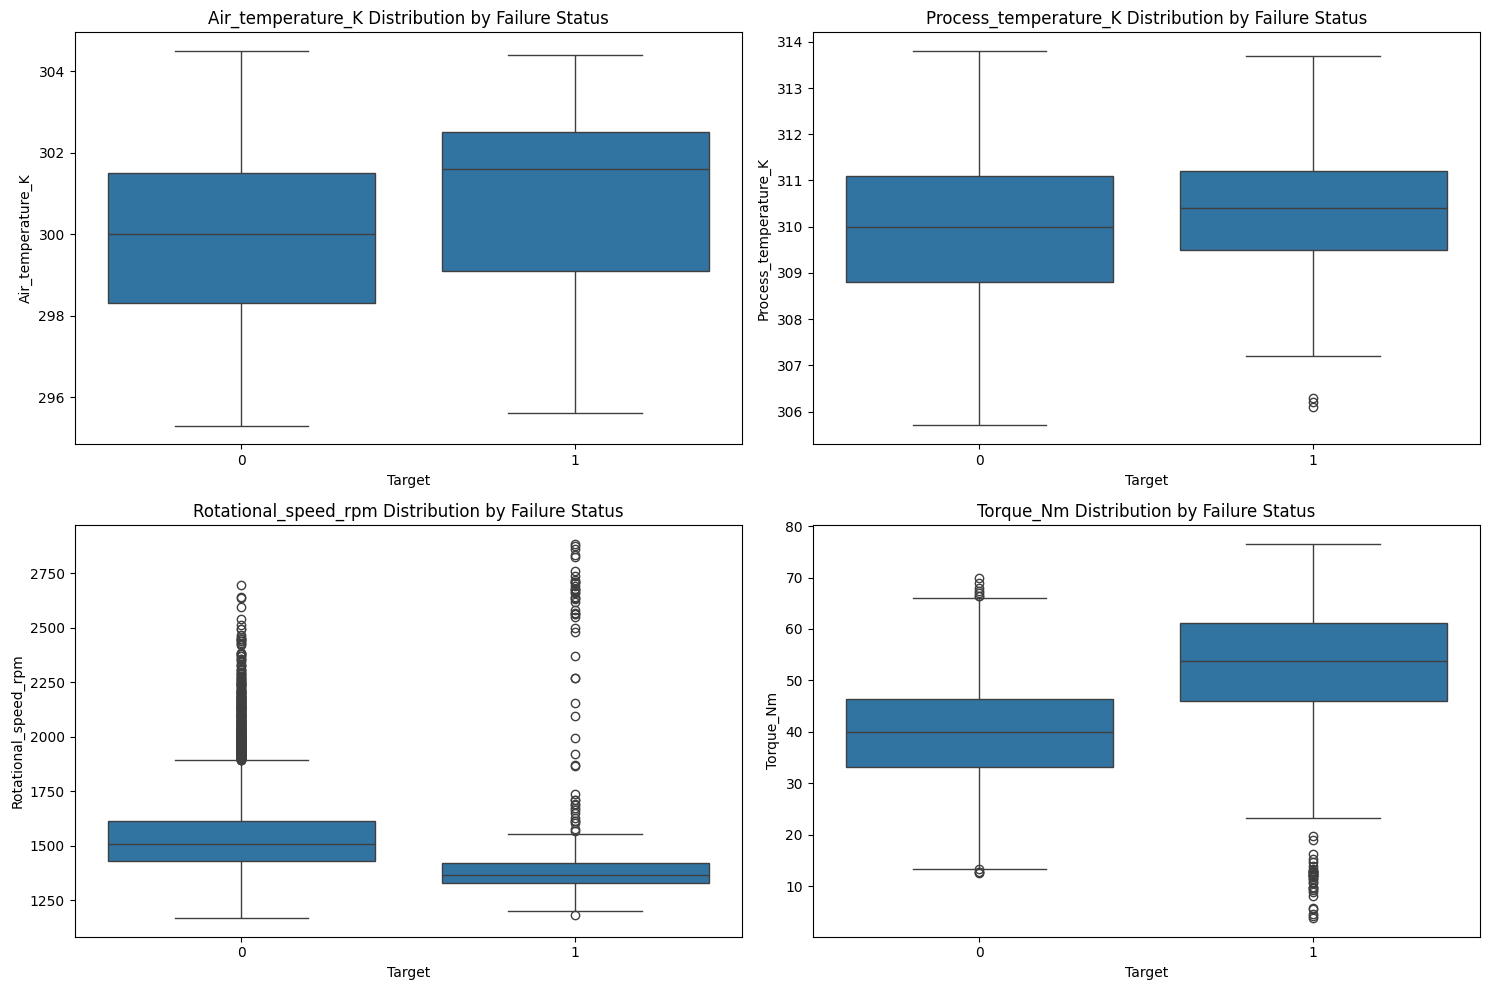


Business Impact Metrics:
------------------------
Total Machines: 10000
Failure Rate: 3.39%
Failure Type Distribution: {'Heat Dissipation Failure': 33.03834808259587, 'Power Failure': 28.023598820058996, 'Overstrain Failure': 23.008849557522122, 'Tool Wear Failure': 13.274336283185843, 'No Failure': 2.6548672566371683}
Estimated Annual Downtime Cost: $13,560,000
Potential Savings With Perfect Prediction: $13,153,200
Downtime Cost Per Failure: $40,000

Random Forest Business Impact:

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1934
           1       0.97      0.99      0.98      1931

    accuracy                           0.98      3865
   macro avg       0.98      0.98      0.98      3865
weighted avg       0.98      0.98      0.98      3865

ROC-AUC Score: 0.9983


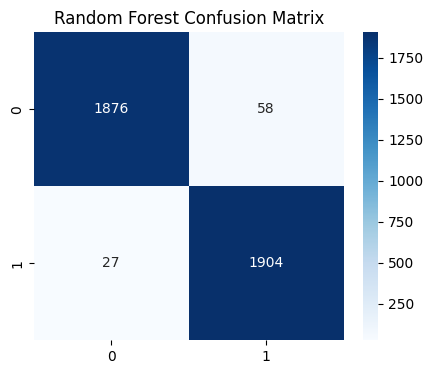


XGBoost Business Impact:

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1934
           1       0.97      1.00      0.98      1931

    accuracy                           0.98      3865
   macro avg       0.98      0.98      0.98      3865
weighted avg       0.98      0.98      0.98      3865

ROC-AUC Score: 0.9990


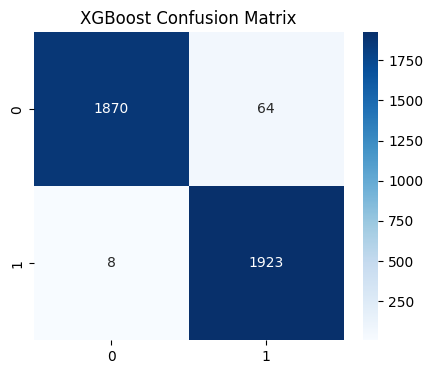

In [10]:
def business_metrics(df):
    """Calculate business-oriented metrics"""
    # Failure rate metrics
    total_machines = len(df)
    failures = df[df['Target'] == 1]
    failure_rate = len(failures)/total_machines * 100

    # Failure type distribution
    failure_type_dist = (failures['Failure_Type'].value_counts(normalize=True) * 100).to_dict()

    # Cost assumptions (customize these based on business reality)
    avg_downtime_cost = 5000  # $ per hour
    avg_repair_time = 8  # hours
    preventive_maintenance_cost = 1200  # $ per intervention

    # Calculate potential savings
    max_potential_savings = len(failures) * avg_downtime_cost * avg_repair_time
    pm_cost = len(failures) * preventive_maintenance_cost

    return {
        'total_machines': total_machines,
        'failure_rate': f"{failure_rate:.2f}%",
        'failure_type_distribution': failure_type_dist,
        'estimated_annual_downtime_cost': f"${max_potential_savings:,.0f}",
        'potential_savings_with_perfect_prediction': f"${max_potential_savings - pm_cost:,.0f}",
        'downtime_cost_per_failure': f"${avg_downtime_cost * avg_repair_time:,.0f}"
    }

def enhanced_eda(df):
    """Expanded exploratory data analysis"""
    # 1. Time-based analysis (if you have temporal data)
    if 'timestamp' in df.columns:
        df['date'] = pd.to_datetime(df['timestamp'])
        plt.figure(figsize=(12,6))
        df.resample('M', on='date')['Target'].mean().plot()
        plt.title('Monthly Failure Rate Trend')
        plt.ylabel('Failure Rate')
        plt.show()

    # 2. Failure type analysis
    plt.figure(figsize=(10,6))
    failure_reasons = df[df['Target'] == 1]['Failure_Type'].value_counts()
    sns.barplot(x=failure_reasons.values, y=failure_reasons.index)
    plt.title('Distribution of Failure Types')
    plt.xlabel('Count')
    plt.show()

    # 3. Machine type analysis
    plt.figure(figsize=(10,6))
    type_failure_rate = df.groupby('Type')['Target'].mean().sort_values(ascending=False)
    sns.barplot(x=type_failure_rate.index, y=type_failure_rate.values)
    plt.title('Failure Rate by Machine Type')
    plt.ylabel('Failure Rate')
    plt.xlabel('Machine Type')
    plt.show()

    # 4. Sensor thresholds analysis
    fig, ax = plt.subplots(2, 2, figsize=(15,10))
    sensors = ['Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm', 'Torque_Nm']
    for i, sensor in enumerate(sensors):
        sns.boxplot(x='Target', y=sensor, data=df, ax=ax[i//2, i%2])
        ax[i//2, i%2].set_title(f'{sensor} Distribution by Failure Status')
    plt.tight_layout()
    plt.show()

    # 5. Maintenance frequency analysis
    if 'Maintenance_Count' in df.columns:
        plt.figure(figsize=(10,6))
        sns.countplot(x='Maintenance_Count', hue='Target', data=df)
        plt.title('Failure Distribution by Maintenance Count')
        plt.show()

# Run enhanced EDA
enhanced_eda(df)

# Calculate and display business metrics
biz_metrics = business_metrics(df)
print("\nBusiness Impact Metrics:")
print("------------------------")
for k, v in biz_metrics.items():
    print(f"{k.replace('_', ' ').title()}: {v}")

#evaluation function with business impact
def evaluate_model(model, model_name, X_test, y_test, cost_matrix):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    # Generate metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)  # THIS LINE WAS MISSING

    # Create metric dictionary
    metrics = {
        'Model': model_name,
        'Accuracy': report['accuracy'],
        'ROC-AUC': roc_auc,
        'Precision (Class 0)': report['0']['precision'],
        'Recall (Class 0)': report['0']['recall'],
        'F1 (Class 0)': report['0']['f1-score'],
        'Precision (Class 1)': report['1']['precision'],
        'Recall (Class 1)': report['1']['recall'],
        'F1 (Class 1)': report['1']['f1-score'],
        'Confusion Matrix': cm
    }

    # Add business impact analysis
    tn, fp, fn, tp = cm.ravel()

    # Calculate financial impact
    cost_fp = fp * cost_matrix['fp_cost']
    cost_fn = fn * cost_matrix['fn_cost']
    savings_tp = tp * cost_matrix['tp_saving']

    net_impact = savings_tp - cost_fp - cost_fn

    metrics.update({
        'false_positives_cost': f"${cost_fp:,.0f}",
        'false_negatives_cost': f"${cost_fn:,.0f}",
        'true_positives_savings': f"${savings_tp:,.0f}",
        'net_impact': f"${net_impact:,.0f}"
    })

    # Print results
    print(f"\n{classification_report(y_test, y_pred)}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return metrics

cost_matrix = {
    'fp_cost': 1200,  # Cost of unnecessary maintenance
    'fn_cost': 5000*8,  # Cost of missed failure (downtime)
    'tp_saving': 5000*8 - 1200  # Savings from prevented failure
}

# Evaluate models with financial impact
print("\nRandom Forest Business Impact:")
rf_metrics = evaluate_model(rf_model, "Random Forest", X_test, y_test, cost_matrix)

print("\nXGBoost Business Impact:")
xgb_metrics = evaluate_model(xgb_model, "XGBoost", X_test, y_test, cost_matrix)

# Create comparison dataframe
results_df = pd.DataFrame([rf_metrics, xgb_metrics]).set_index('Model')